## setup

In [52]:
%matplotlib inline
import glob
import sys
import shutil
import os
import matplotlib.pyplot as plt
from mintpy import workflow, view, tsview, plot_network, plot_transection, plot_coherence_matrix
from mintpy.unwrap_error_phase_closure import plot_num_triplet_with_nonzero_integer_ambiguity

['load_data', 'modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error']
  ['invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography']
  ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']

In [27]:
cd /home/fw/data/poroa_new

/home/fw/data/poroa_new


## load_data

In [37]:
!smallbaselineApp.py ../hyp3_insar/hyp3.cfg --dostep load_data

MintPy release version v1.3.0-89, release date 2021-08-05
--RUN-at-2021-08-13 16:26:39.258271--
Current directory: /home/fw/data/poroa_new
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: hyp3
Go to work directory: /home/fw/data/poroa_new
read custom template file: /home/fw/data/hyp3_insar/hyp3.cfg
update default template based on input custom template
    mintpy.load.unwFile: /mnt/f/hyp3_downloads/p81f1048_10x2_2/\*/\*unw_phase_clip.tif --> /mnt/f/hyp3_downloads/p81f1048_10x2_2/*/*unw_phase_clip.tif
    mintpy.load.corFile: /mnt/f/hyp3_downloads/p81f1048_10x2_2/\*/\*corr_clip.tif --> /mnt/f/hyp3_downloads/p81f1048_10x2_

view.py inputs/geometryGeo.h5 height --noverbose


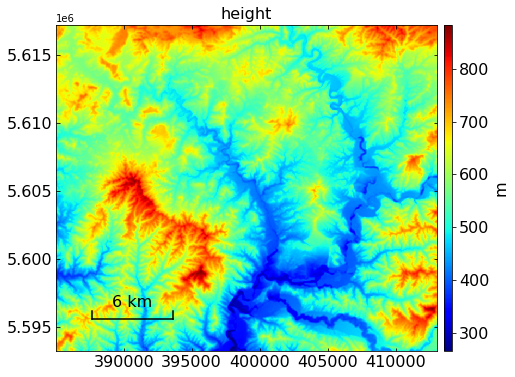

In [38]:
view.main('inputs/geometryGeo.h5 height --noverbose'.split())

## generate_mask

In [39]:
!generate_mask.py inputs/geometryGeo.h5 waterMask -M 0.5 -o waterMask.h5

input geometry file: inputs/geometryGeo.h5
read inputs/geometryGeo.h5 waterMask
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value > 0.5
delete exsited file: waterMask.h5
create HDF5 file: waterMask.h5 with w mode
create dataset /mask of bool       in size of (600, 700)           with compression=None
finished writing to waterMask.h5
time used: 00 mins 0.1 secs.


view.py waterMask.h5 --noverbose


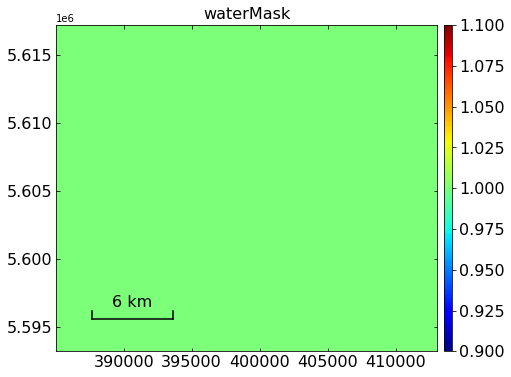

In [40]:
view.main('waterMask.h5 --noverbose'.split())

## subset

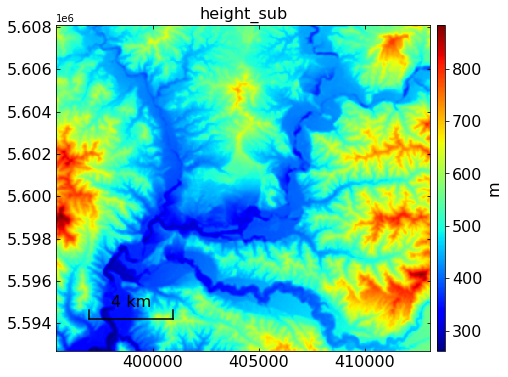

In [23]:
view.main('inputs/geometryGeo.h5 height --sub-x 2876 3317 --sub-y 896 1281 --noverbose'.split())

In [37]:
!subset.py inputs/ifgramStack.h5 -o inputs/ifgramStackPoroa.h5 -x 2876 3317 -y 896 1281
!subset.py inputs/geometryGeo.h5 -o inputs/geometryGeoPoroa.h5 -x 2876 3317 -y 896 1281
!subset.py inputs/waterMask.h5 -o inputs/waterMaskPoroa.h5 -x 2876 3317 -y 896 1281

------------------------------
subset ifgramStack file: inputs/ifgramStack.h5 ...
data   range in (x0,y0,x1,y1): (0, 0, 4330, 2120)
subset range in (x0,y0,x1,y1): (2876, 896, 3317, 1281)
data   range in (W, N, E, S): (280400.0, 5643920.0, 453600.0, 5559120.0)
subset range in (W, N, E, S): (395440.0, 5608080.0, 413080.0, 5592680.0)
writing >>> inputs/ifgramStackPoroa.h5
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 3760/5128/4201/5513
update Y/X_FIRST
--------------------------------------------------
grab dataset structure from ref_file: inputs/ifgramStack.h5
create HDF5 file: inputs/ifgramStackPoroa.h5 with w mode
create dataset  : bperp       of float32                   in size of (277,)               with compression = None
create dataset  : coherence   of float32                   in size of (277, 385, 441)      with compression = None
create dataset  : date        of |S8                       in size of (277, 2)             with compression = None
create dat

## double_difference

In [41]:
!spatial_filter.py inputs/ifgramStack.h5 unwrapPhase -o inputs/ifgramStackDD.h5  -f double_difference -p 1 12

filtering ifgramStack file: inputs/ifgramStack.h5 using double_difference filter with local/regional kernel sizes of 1/12
filtering unwrapPhase from ifgramStack.h5  277/277 ...
create HDF5 file: inputs/ifgramStackDD.h5 with w mode
create dataset /coherence   of float32    in size of (277, 600, 700)      with compression=None
create dataset /unwrapPhase of float32    in size of (277, 600, 700)      with compression=None
create dataset /bperp       of float32    in size of (277,)     with compression=None
create dataset /date        of |S8        in size of (277, 2)   with compression=None
create dataset /dropIfgram  of bool       in size of (277,)     with compression=None
finished writing to inputs/ifgramStackDD.h5
Done.


## transfer files

In [42]:
# New Version
!mv inputs/ifgramStack.h5 inputs/ifgramStack_raw.h5
!mv inputs/ifgramStackDD.h5 inputs/ifgramStack.h5

# Old Version
# # reset inputs directory
# mv inputs/ inputs_raw/
# mkdir inputs
# !cp inputs_raw/ifgramStackPoroaDD.h5 inputs/ifgramStack.h5
# !cp inputs_raw/geometryGeoPoroa.h5 inputs/geometryGeo.h5
# !cp inputs_raw/waterMaskPoroa.h5 ./waterMask.h5
# !cp inputs_raw/*.cfg inputs/

## modify_network

In [48]:
!modify_network.py inputs/ifgramStack.h5 --reset
!smallbaselineApp.py ../hyp3_insar/hyp3.cfg --dostep modify_network

No lookup table info range/lat found in files.
--------------------------------------------------
reset dataset 'dropIfgram' to True for all interferograms for file: inputs/ifgramStack.h5
touch coherenceSpatialAvg.txt
MintPy release version v1.3.0-89, release date 2021-08-05
--RUN-at-2021-08-16 09:00:03.240233--
Current directory: /home/fw/data/poroa_new
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: hyp3
Go to work directory: /home/fw/data/poroa_new
read custom template file: /home/fw/data/hyp3_insar/hyp3.cfg
update default template based on input custom template
No new option value found, skip updating /home/fw/data/poroa_new/sma

## reference_point

In [49]:
!smallbaselineApp.py ../hyp3_insar/hyp3.cfg --dostep reference_point

MintPy release version v1.3.0-89, release date 2021-08-05
--RUN-at-2021-08-16 09:00:18.209721--
Current directory: /home/fw/data/poroa_new
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: hyp3
Go to work directory: /home/fw/data/poroa_new
read custom template file: /home/fw/data/hyp3_insar/hyp3.cfg
update default template based on input custom template
No new option value found, skip updating /home/fw/data/poroa_new/smallbaselineApp.cfg
read default template file: /home/fw/data/poroa_new/smallbaselineApp.cfg


******************** step - reference_point ********************
Input data seems to be geocoded. Lookup file not needed.

generate_mask.py /ho

## quick_overview

In [50]:
!smallbaselineApp.py ../hyp3_insar/hyp3.cfg --dostep quick_overview

MintPy release version v1.3.0-89, release date 2021-08-05
--RUN-at-2021-08-16 09:00:33.281471--
Current directory: /home/fw/data/poroa_new
Run routine processing with smallbaselineApp.py on steps: ['quick_overview']
Remaining steps: ['correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: hyp3
Go to work directory: /home/fw/data/poroa_new
read custom template file: /home/fw/data/hyp3_insar/hyp3.cfg
update default template based on input custom template
No new option value found, skip updating /home/fw/data/poroa_new/smallbaselineApp.cfg
read default template file: /home/fw/data/poroa_new/smallbaselineApp.cfg


******************** step - quick_overview ********************
Input data seems to be geocoded. Lookup file not needed.

temporal_average.py /home/fw/data/poroa_

view.py avgPhaseVelocity.h5 --noverbose -m waterMask.h5 --vlim -3 3


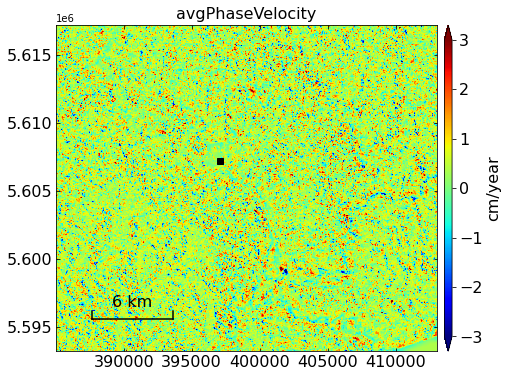

plot and save figure to file numTriNonzeroIntAmbiguity.png


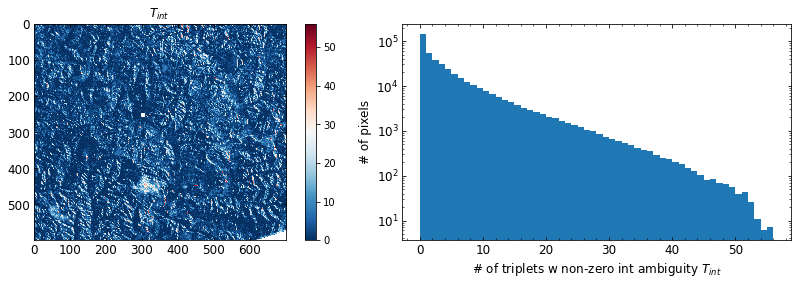

In [53]:
view.main('avgPhaseVelocity.h5 --noverbose -m waterMask.h5 --vlim -3 3'.split())
plot_num_triplet_with_nonzero_integer_ambiguity('numTriNonzeroIntAmbiguity.h5', display=True, fig_size=[12, 4])

## correct_unwrap_error

In [54]:
!smallbaselineApp.py ../hyp3_insar/hyp3.cfg --dostep correct_unwrap_error

MintPy release version v1.3.0-89, release date 2021-08-05
--RUN-at-2021-08-16 09:03:26.630044--
Current directory: /home/fw/data/poroa_new
Run routine processing with smallbaselineApp.py on steps: ['correct_unwrap_error']
Remaining steps: ['invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: hyp3
Go to work directory: /home/fw/data/poroa_new
read custom template file: /home/fw/data/hyp3_insar/hyp3.cfg
update default template based on input custom template
No new option value found, skip updating /home/fw/data/poroa_new/smallbaselineApp.cfg
read default template file: /home/fw/data/poroa_new/smallbaselineApp.cfg


******************** step - correct_unwrap_error ********************
phase-unwrapping error correction is OFF.
Go back to directory: /home/fw/data/poroa_new

#####################

## invert_network

In [65]:
!smallbaselineApp.py ../hyp3_insar/hyp3.cfg --dostep invert_network

MintPy release version v1.3.0-89, release date 2021-08-05
--RUN-at-2021-08-16 09:17:40.635976--
Current directory: /home/fw/data/poroa_new
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: hyp3
Go to work directory: /home/fw/data/poroa_new
read custom template file: /home/fw/data/hyp3_insar/hyp3.cfg
update default template based on input custom template
    mintpy.load.unwFile: /mnt/f/hyp3_downloads/p81f1048_10x2_2/\*/\*unw_phase_clip.tif --> /mnt/f/hyp3_downloads/p81f1048_10x2_2/*/*unw_phase_clip.tif
    mintpy.load.corFile: /mnt/f/hyp3_downloads/p81f1048_10x2_2/\*/\*corr_clip.tif --> /mnt/f/hyp3_downloads/p81f1048_10x2_2/*/*corr_clip.tif
    mintpy.load.demFile: /mnt/f/hyp3_downloads/p81f1048_10x2_2/\*/S1BB_20

## corrections

In [75]:
!smallbaselineApp.py ../hyp3_insar/hyp3.cfg --start correct_LOD --stop deramp
!smallbaselineApp.py ../hyp3_insar/hyp3.cfg --start correct_topography --stop reference_date


___________________________________________________________

  /##      /## /##             /##     /#######           
 | ###    /###|__/            | ##    | ##__  ##          
 | ####  /#### /## /#######  /######  | ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ##|_  ##_/  | #######/| ##  | ##
 | ##  ###| ##| ##| ##  \ ##  | ##    | ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  | ##  | ## /##| ##      | ##  | ##
 | ## \/  | ##| ##| ##  | ##  |  ####/| ##      |  #######
 |__/     |__/|__/|__/  |__/   \___/  |__/       \____  ##
                                                 /##  | ##
                                                |  ######/
   Miami InSAR Time-series software in Python    \______/ 
          MintPy v1.3.0-89, 2021-08-05
___________________________________________________________

--RUN-at-2021-08-16 10:33:13.696898--
Current directory: /home/fw/data/poroa_new
Run routine processing with smallbaselineApp.py on steps: ['correct_LOD', 'correct_SET', 'correct_tropospher

## velocity

In [76]:
!smallbaselineApp.py ../hyp3_insar/hyp3.cfg --dostep velocity

MintPy release version v1.3.0-89, release date 2021-08-05
--RUN-at-2021-08-16 10:33:21.476596--
Current directory: /home/fw/data/poroa_new
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: hyp3
Go to work directory: /home/fw/data/poroa_new
read custom template file: /home/fw/data/hyp3_insar/hyp3.cfg
update default template based on input custom template
No new option value found, skip updating /home/fw/data/poroa_new/smallbaselineApp.cfg
read default template file: /home/fw/data/poroa_new/smallbaselineApp.cfg


******************** step - velocity ********************

timeseries2velocity.py /home/fw/data/poroa_new/timeseries.h5 -t /home/fw/data/poroa_new/smallbaselineApp.cfg -o /home/fw/data/poroa_new/velocity.h5 --update
read options from template file: smallbaselineApp.cfg
open timeseries file: timeseries.h5
-----------------------------------

## view results

view.py velocity.h5 --noverbose


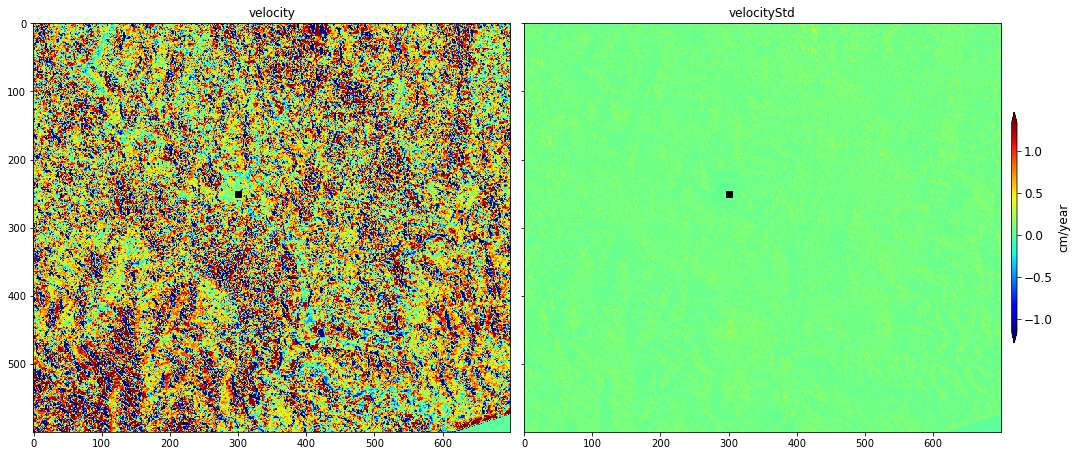

In [77]:
view.main('velocity.h5 --noverbose'.split())